In [1]:
import numpy as np 
import pandas as pd 
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 as PTModel
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
from vis.visualization import visualize_saliency
from vis.utils import utils
import numpy as np
import matplotlib.image as mpimg
import argparse
import cv2
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Uncomment the below codes for downloading the data

#!gdown https://drive.google.com/open?id=1odxJF4kyHEtBqhkvz3iXpV3iQK34m6z0
#!unzip covid_data_compiled_sagar.zip

In [3]:
## Global variables
data_list = os.listdir('multi_class/train')
DATASET_PATH  = 'multi_class/train'
test_dir =  'multi_class/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 80
LEARNING_RATE =0.00001


## Loading Data and Augmentation


In [4]:
def augment(training=True):
    

    # Train Image Augmentation
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=50,
                                       featurewise_center = True,
                                       featurewise_std_normalization = True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.25,
                                       zoom_range=0.1,
                                       zca_whitening = True,
                                       channel_shift_range = 20,
                                       horizontal_flip = True ,
                                       vertical_flip = True ,
                                       validation_split = 0.2,
                                       fill_mode='constant')

    
    if training == True:
        

        batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                          target_size=IMAGE_SIZE,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          subset = "training",
                                                          seed=42,
                                                          class_mode="categorical"
                                                          )
    else:
        
        batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="categorical"
                                                  )
        

    return batches

## Creating model architecture and using VGG 16 with Imagenet weights as initial layer and using attention as an additive model.

We don't want to do any pooling since some parts of the image are more important than the others. So we build an attention mechanism to turn pixels in the GAP on an off. Then the pooling and then rescale (Lambda layer) happens based on the number of pixels.

In [5]:
def model_attention(learning_rate = LEARNING_RATE):
    base_pretrained_model = PTModel(input_shape =  (150, 150, 3), 
                              include_top = False, weights = 'imagenet')
    base_pretrained_model.trainable = False
    model = models.Sequential()
    pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
    pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
    bn_features = BatchNormalization()(pt_features)
    # here we do an attention mechanism to turn pixels in the GAP on an off
    attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'elu')(bn_features)
    attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
    attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
    attn_layer = AvgPool2D((2,2), strides = (1,1), padding = 'same')(attn_layer) # smooth results
    attn_layer = Conv2D(1, 
                        kernel_size = (1,1), 
                        padding = 'valid', 
                        activation = 'sigmoid')(attn_layer)
    # branch it to all channel
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
                   activation = 'linear', use_bias = False, weights = [up_c2_w])
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)
    mask_features = multiply([attn_layer, bn_features])
    gap_features = GlobalAveragePooling2D()(mask_features)
    gap_mask = GlobalAveragePooling2D()(attn_layer)
    # to account for missing values from the attention model
    gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    gap_dr = Dropout(0.5)(gap)
    dr_steps = Dropout(0.5)(Dense(128, activation = 'elu')(gap_dr))
    out_layer = Dense(3, activation = 'softmax')(dr_steps)
    attn_model = Model(inputs = [pt_features], outputs = [out_layer], name = 'attention_model')

    attn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                               metrics = ['acc'])
    
    print('Summary of Attention model only: ')
    print(attn_model.summary())
    
    

    
    tb_model = Sequential(name = 'combined_model')
    base_pretrained_model.trainable = False
    tb_model.add(base_pretrained_model)
    tb_model.add(attn_model)
    tb_model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy',
                               metrics = ['acc'])
    print("Summary of final model: ")
    print(tb_model.summary())
    
    return tb_model

In [6]:
def callback():
    weight_path="{}_weights.best.hdf5".format('covid_attn')
    checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
    '''early = EarlyStopping(monitor="val_loss", 
                          mode="min", 
                          patience=10)''' # probably needs to be more patient, but kaggle time is limited
    callbacks_list = [checkpoint, reduceLROnPlat]
    
    return callbacks_list

In [7]:
def fit_model(model, train_batches, valid_batches, callbacks_list):
    
    STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
    STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size
    
    result = model.fit_generator(train_batches, 
                       steps_per_epoch =STEP_SIZE_TRAIN,
                      validation_data = valid_batches, 
                       validation_steps = STEP_SIZE_VALID,
                      epochs = 100, 
                      callbacks = callbacks_list,
                      workers = 3)
    
    return result

In [8]:
def plot_results(result, epochs = 100):

    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [9]:
def check_test_data_and_image_map(model, test_dir=test_dir, target_size=IMAGE_SIZE, batch_size = BATCH_SIZE):
    
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    eval_generator = test_datagen.flow_from_directory(
     test_dir,target_size=IMAGE_SIZE,
     batch_size=1,
     shuffle=False,
     seed=42, 
     class_mode='categorical')

    eval_generator.reset()
    x = model.evaluate_generator(eval_generator,
     steps = np.ceil(len(eval_generator) / BATCH_SIZE),
     use_multiprocessing = False,
     verbose = 1,
     workers=1
     )
    print('Test loss:' , x[0])
    print('Test accuracy:',x[1])
    
    eval_generator.reset()  
    pred = model.predict_generator(eval_generator,1000,verbose=1)
    
    for index, probability in enumerate(pred):
        try:
            image_path = test_dir + "/" +eval_generator.filenames[index]
            image = mpimg.imread(image_path)
            #BGR TO RGB conversion using CV2
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            pixels = np.array(image)
            plt.imshow(pixels)

            print(eval_generator.filenames[index])
            if np.argmax(probability) == 0:
                plt.title("%.2f" % (probability[0]*100) + "% COVID19")
            elif np.argmax(probability) == 1:
                plt.title("%.2f" % (probability[1]*100) + "% Normal")
            else:
                plt.title("%.2f" % (probability[2]*100) + "% Tertiary pneumonia")
            plt.show()
        except:
            continue




In [10]:
def main():
    train_batches = augment()
    valid_batches = augment(False)
    model = model_attention()
    callback_list = callback()
    result = fit_model(model, train_batches, valid_batches, callback_list)
    plot_results(result, epochs = 100)
    check_test_data_and_image_map(model)

/home/sagarnil/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 160 images belonging to 3 classes.
Found 40 images belonging to 3 classes.
Summary of Attention model only: 
Model: "attention_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      [(None, 4, 4, 512)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4, 4, 512)    2048        feature_input[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 4, 4, 128)    65664       batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 4, 32)     4128        con

/home/sagarnil/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/sagarnil/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15/16 [===========================>..] - ETA: 0s - loss: 1.2701 - acc: 0.3800
Epoch 00001: val_loss improved from inf to 1.08763, saving model to covid_attn_weights.best.hdf5
16/16 [==============================] - 4s 251ms/step - loss: 1.2503 - acc: 0.3875 - val_loss: 1.0876 - val_acc: 0.5500
Epoch 2/100
15/16 [===========================>..] - ETA: 0s - loss: 0.8768 - acc: 0.6333
Epoch 00002: val_loss improved from 1.08763 to 0.99514, saving model to covid_attn_weights.best.hdf5
16/16 [==============================] - 2s 132ms/step - loss: 0.8680 - acc: 0.6375 - val_loss: 0.9951 - val_acc: 0.4500
Epoch 3/100
15/16 [===========================>..] - ETA: 0s - loss: 0.8572 - acc: 0.6467
Epoch 00003: val_loss improved from 0.99514 to 0.88870, saving model to covid_attn_weights.best.hdf5
16/16 [==============================] - 2s 126ms/step - loss: 0.8339 - acc: 0.6500 - val_loss: 0.8887 - val_acc: 0.5750
Epoch 4/100
15/16 [===========================>..] - ETA: 0s - loss: 0.7860 - ac

15/16 [===========================>..] - ETA: 0s - loss: 0.5167 - acc: 0.8067
Epoch 00029: val_loss improved from 0.43772 to 0.32750, saving model to covid_attn_weights.best.hdf5
16/16 [==============================] - 2s 133ms/step - loss: 0.4933 - acc: 0.8125 - val_loss: 0.3275 - val_acc: 0.8500
Epoch 30/100
15/16 [===========================>..] - ETA: 0s - loss: 0.4840 - acc: 0.8133
Epoch 00030: val_loss did not improve from 0.32750
16/16 [==============================] - 2s 130ms/step - loss: 0.4721 - acc: 0.8188 - val_loss: 0.4673 - val_acc: 0.8000
Epoch 31/100
15/16 [===========================>..] - ETA: 0s - loss: 0.5462 - acc: 0.7733
Epoch 00031: val_loss did not improve from 0.32750
16/16 [==============================] - 2s 128ms/step - loss: 0.6239 - acc: 0.7375 - val_loss: 0.5222 - val_acc: 0.7500
Epoch 32/100
15/16 [===========================>..] - ETA: 0s - loss: 0.4721 - acc: 0.8267
Epoch 00032: val_loss did not improve from 0.32750
16/16 [=========================

15/16 [===========================>..] - ETA: 0s - loss: 0.5012 - acc: 0.8000
Epoch 00059: val_loss did not improve from 0.29380
16/16 [==============================] - 2s 120ms/step - loss: 0.5236 - acc: 0.7937 - val_loss: 0.5879 - val_acc: 0.6750
Epoch 60/100
15/16 [===========================>..] - ETA: 0s - loss: 0.3919 - acc: 0.8667
Epoch 00060: val_loss did not improve from 0.29380
16/16 [==============================] - 2s 130ms/step - loss: 0.3965 - acc: 0.8625 - val_loss: 0.4254 - val_acc: 0.8000
Epoch 61/100
15/16 [===========================>..] - ETA: 0s - loss: 0.3588 - acc: 0.8400
Epoch 00061: val_loss did not improve from 0.29380
16/16 [==============================] - 2s 135ms/step - loss: 0.3831 - acc: 0.8250 - val_loss: 0.6192 - val_acc: 0.7500
Epoch 62/100
15/16 [===========================>..] - ETA: 0s - loss: 0.4546 - acc: 0.8333
Epoch 00062: val_loss did not improve from 0.29380
16/16 [==============================] - 2s 128ms/step - loss: 0.4397 - acc: 0.837

15/16 [===========================>..] - ETA: 0s - loss: 0.4028 - acc: 0.8467
Epoch 00089: val_loss improved from 0.28028 to 0.23203, saving model to covid_attn_weights.best.hdf5
16/16 [==============================] - 2s 134ms/step - loss: 0.4100 - acc: 0.8438 - val_loss: 0.2320 - val_acc: 0.9250
Epoch 90/100
15/16 [===========================>..] - ETA: 0s - loss: 0.3245 - acc: 0.8800
Epoch 00090: val_loss did not improve from 0.23203
16/16 [==============================] - 2s 127ms/step - loss: 0.3141 - acc: 0.8875 - val_loss: 0.3560 - val_acc: 0.8500
Epoch 91/100
15/16 [===========================>..] - ETA: 0s - loss: 0.4891 - acc: 0.8067
Epoch 00091: val_loss did not improve from 0.23203
16/16 [==============================] - 2s 134ms/step - loss: 0.4731 - acc: 0.8188 - val_loss: 0.5732 - val_acc: 0.7750
Epoch 92/100
15/16 [===========================>..] - ETA: 0s - loss: 0.5047 - acc: 0.8467
Epoch 00092: val_loss did not improve from 0.23203
16/16 [=========================

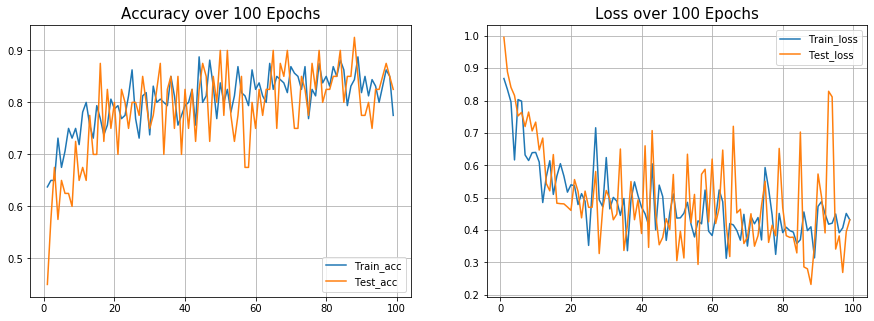

Found 27 images belonging to 3 classes.
3/3 [==============================] - 0s 103ms/step - loss: 0.2196 - acc: 1.0000
Test loss: 0.21957573294639587
Test accuracy: 1.0
1000/1000 [==============================] - 24s 24ms/step
covid/nejmoa2001191_f3-PA.jpeg


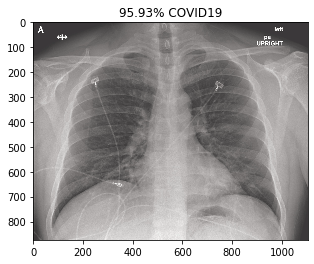

covid/nejmoa2001191_f4.jpeg


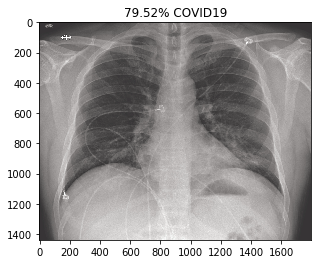

covid/nejmoa2001191_f5-PA.jpeg


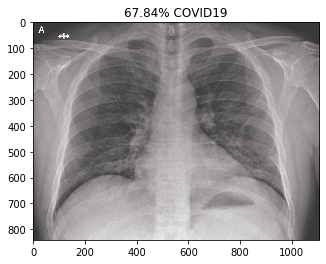

covid/radiol.2020200490.fig3.jpeg


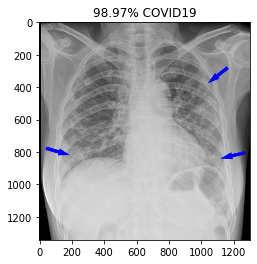

covid/ryct.2020200028.fig1a.jpeg


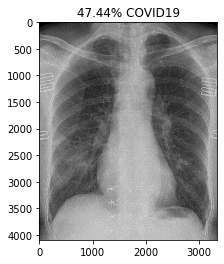

covid/ryct.2020200034.fig2.jpeg


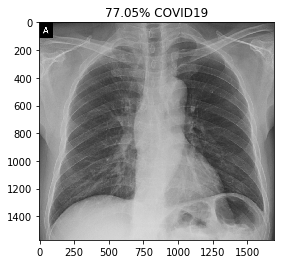

covid/ryct.2020200034.fig5-day0.jpeg


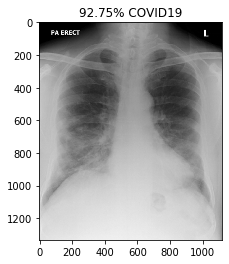

covid/ryct.2020200034.fig5-day4.jpeg


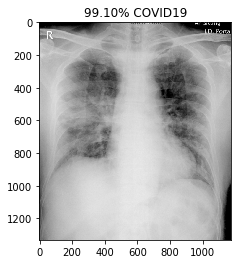

covid/ryct.2020200034.fig5-day7.jpeg


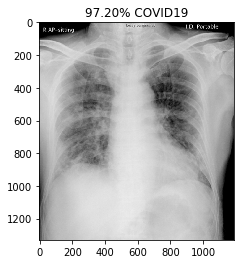

normal/NORMAL2-IM-1385-0001.jpeg


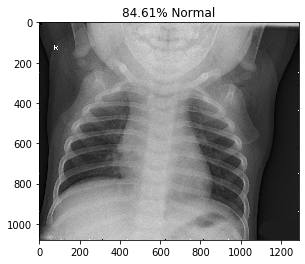

normal/NORMAL2-IM-1396-0001.jpeg


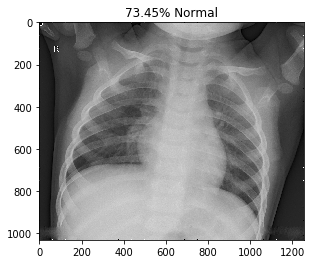

normal/NORMAL2-IM-1400-0001.jpeg


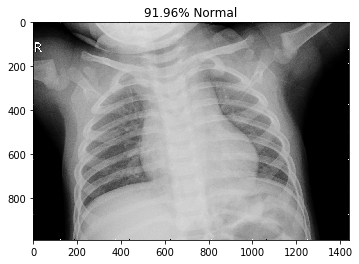

normal/NORMAL2-IM-1401-0001.jpeg


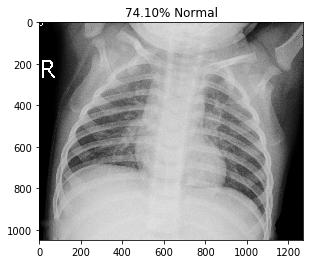

normal/NORMAL2-IM-1406-0001.jpeg


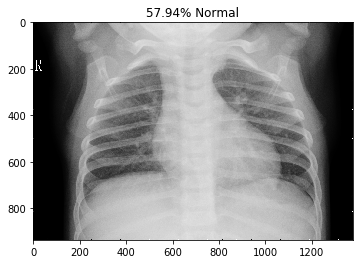

normal/NORMAL2-IM-1412-0001.jpeg


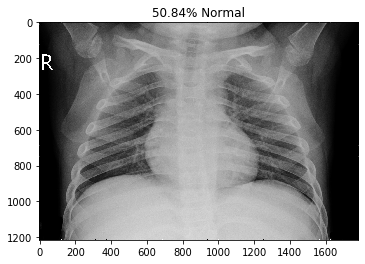

normal/NORMAL2-IM-1419-0001.jpeg


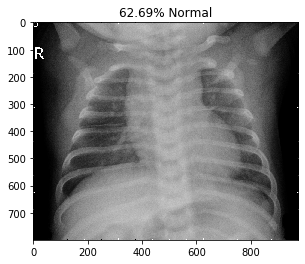

normal/NORMAL2-IM-1422-0001.jpeg


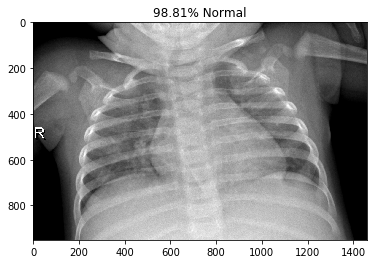

normal/NORMAL2-IM-1423-0001.jpeg


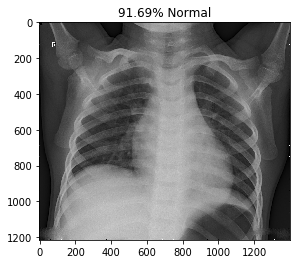

pneumonia_bac/person1753_bacteria_4594.jpeg


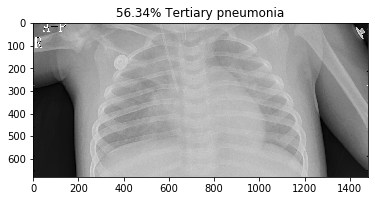

pneumonia_bac/person1940_bacteria_4859.jpeg


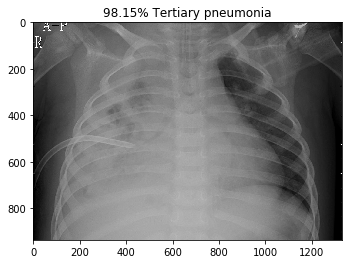

pneumonia_bac/person1940_bacteria_4861.jpeg


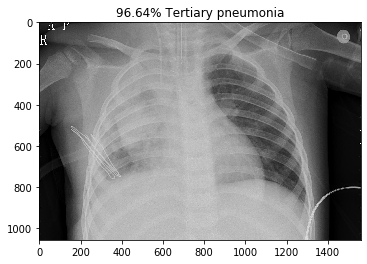

pneumonia_bac/person1940_bacteria_4862.jpeg


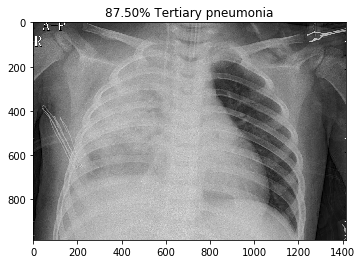

pneumonia_bac/person1941_bacteria_4863.jpeg


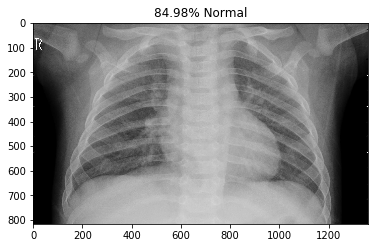

pneumonia_bac/person1942_bacteria_4865.jpeg


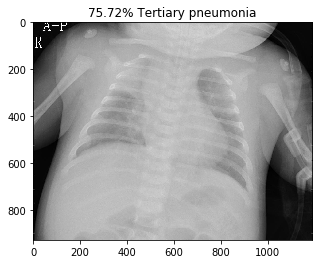

pneumonia_bac/person1943_bacteria_4868.jpeg


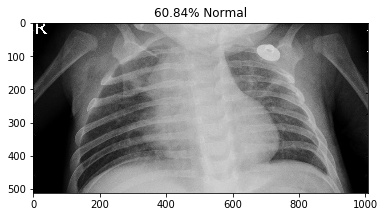

pneumonia_bac/person1944_bacteria_4869.jpeg


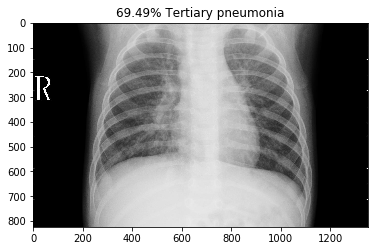

pneumonia_bac/person1945_bacteria_4872.jpeg


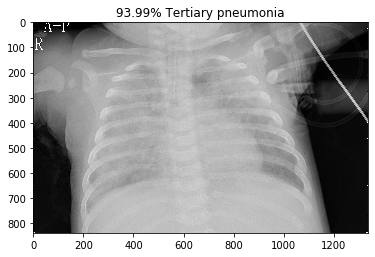

In [11]:
if __name__ == '__main__':
    main()